In [2]:
import sigfig
import polars as pl
from refnx.analysis import Transform, GlobalObjective

import pyref.fitting as fit
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt


In [3]:
energies = np.linspace(280, 290, 100)


ooc = pd.read_csv("/home/hduva/projects/xrr_notebooks/fitting/optical_constants.csv")
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def setp_from_tensor(slab, tensor):
    """Set parameters from tensor."""
    rbounds = (
        tensor.real.min() * 0.9,
        tensor.real.max() * 1.1,
    )
    ibounds = (
        1e-8,
        tensor.imag.max() * 1.1,
    )
    slab.sld.xx.setp(vary=True, bounds=rbounds)
    slab.sld.zz.setp(vary=True, bounds=rbounds)
    slab.sld.ixx.setp(vary=True, bounds=ibounds)
    slab.sld.izz.setp(vary=True, bounds=ibounds)
    return slab


def force_isotropic_beta(slab):
    """Force beta to be isotropic."""
    slab.sld.beta.setp(vary=True, bounds=slab.sld.ixx.bounds)
    slab.sld.ixx.setp(vary=None, constraint=slab.sld.beta)
    slab.sld.izz.setp(vary=None, constraint=slab.sld.beta)


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.44):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False, bounds=(2, 3))
    return slab


def sio2(energy, thick=8.7, rough=5.8, density=2.15):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(8, 12))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=False, bounds=(1, 2.3))
    return slab


def contamination(energy, thick=11.5, rough=4.19, density=1.8, theta=MA):
    """Contamination."""
    name = f"Contamination_{energy}"
    slab = fit.UniTensorSLD(ooc, density=density, rotation=0, energy=energy, name=name)(
        thick, rough
    )
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(value=theta, vary=True, bounds=(0, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def surface(energy, thick=5.5, rough=4.4, density=1.46, theta=0.5):
    """Surface."""
    name = f"Surface_{energy}"
    slab = fit.UniTensorSLD(ooc, density=density, rotation=0, energy=energy, name=name)(
        thick, rough
    )
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(value=theta, vary=True, bounds=(0, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def znpc(energy, thick=183.3, rough=8.8, density=1.654, theta=1.35):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=theta, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1.2, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(MA, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(180, 210))
    slab.rough.setp(vary=True, bounds=(2, 16))
    return slab


def construct_slab(energy, offset=0, rotations=[0, 1.21, MA]):
    """Construct the slab."""
    offset_energy = round(energy + offset, 1)
    slab = (
        vacuum(offset_energy)
        | surface(offset_energy, theta=rotations[0])
        | znpc(offset_energy, theta=rotations[1])
        | contamination(offset_energy, theta=rotations[2])
        | sio2(offset_energy)
        | substrate(offset_energy)
    )
    slab.name = f"Monolayer_{energy}"
    return slab

In [ ]:
q = lambda theta, energy: (4 * np.pi * np.sin(np.radians(theta)) * energy / 12398.42)  # noqa: E731


def fixed_angle(energy: np.ndarray, theta: float, pol="s", orientations=[0.8, 0.1, MA]):
    fixed_angle_vals = np.empty_like(energy, dtype=float)
    for i, e in enumerate(energy):
        model_func = fit.ReflectModel(
            construct_slab(e, rotations=orientations),
            pol=pol,
            energy=e,
        )
        q_values = q(theta, e)
        fixed_angle_vals[i] = model_func(q_values)
    return fixed_angle_vals

/tmp/ipykernel_2911455/209978989.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fixed_angle_vals[i] = model_func(q_values)


(100,)

In [18]:
#  plot the s pol data and p pol data
theta = [10, 25, 50]
interfaces = np.linspace(0, np.pi / 2, 100)

anisotropy_ratio = np.zeros((len(theta), len(interfaces), len(energies)))
for j, itheta in enumerate(interfaces):
    orientation = [0.1, 0.1, itheta]
    for i, t in enumerate(theta):
        s_data = fixed_angle(energies, t, pol="s", orientations=orientation)
        p_data = fixed_angle(energies, t, pol="p", orientations=orientation)
        anisotropy_ratio[i, j, :] = (s_data - p_data) / (s_data + p_data)

/tmp/ipykernel_2911455/209978989.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fixed_angle_vals[i] = model_func(q_values)


/tmp/ipykernel_2911455/2192131189.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


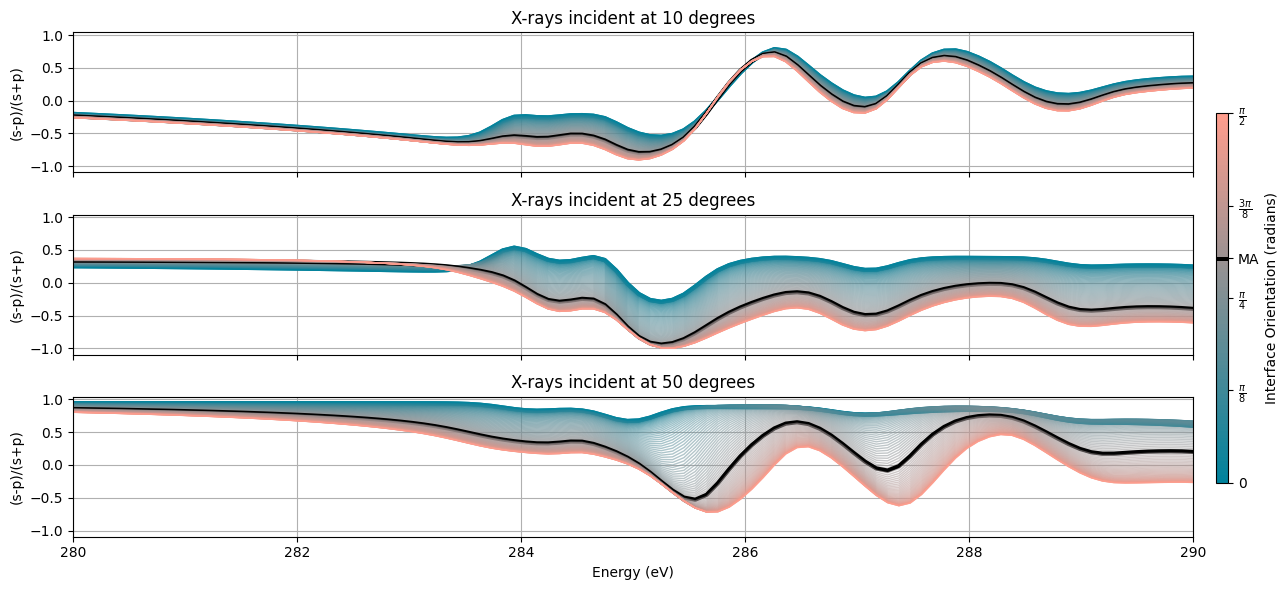

In [54]:
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Create base color palette
base_cmap = sns.color_palette("blend:#00829c,#ff9d8d", n_colors=len(interfaces))

# Find the interface closest to MA
ma_index = np.argmin(np.abs(interfaces - MA))

# Replace the color at MA index with black
cmap = base_cmap.copy()
cmap[ma_index] = (0, 0, 0)  # Black color for MA

fig, ax = plt.subplots(nrows=3, figsize=(12, 6), sharex=True, sharey=True)

for i, t in enumerate(theta):
    # Plot all interface orientations
    for j in range(len(interfaces)):
        if j == ma_index:
            # Plot MA interface in black
            ax[i].plot(
                energies,
                anisotropy_ratio[i, j, :],
                "k-",
                linewidth=3,
            )
        else:
            # Color code by interface orientation
            color = cmap[j]
            ax[i].plot(
                energies,
                anisotropy_ratio[i, j, :],
                color=color,
                alpha=0.5 if j not in [0, len(theta) - 1] else 1,
                linewidth=1 if j not in [0, len(theta) - 1] else 3,
            )

    ax[i].set_ylabel("(s-p)/(s+p)")
    ax[i].set_title(f"X-rays incident at {t} degrees")
    ax[i].set_xlim(energies.min(), energies.max())
    ax[i].grid()

# Add colorbar with black at MA position
ax[2].set_xlabel("Energy (eV)")
cmap_mpl = ListedColormap(cmap)
sm = plt.cm.ScalarMappable(
    cmap=cmap_mpl, norm=plt.Normalize(vmin=interfaces.min(), vmax=interfaces.max())
)
sm.set_array([])
cbar = fig.colorbar(
    sm, ax=ax, location="right", pad=0.02, shrink=0.8, aspect=30, anchor=(2.1, 0.5)
)
tick_labels = [
    "0",
    r"$\frac{\pi}{8}$",
    r"$\frac{\pi}{4}$",
    "MA",
    r"$\frac{3\pi}{8}$",
    r"$\frac{\pi}{2}$",
]
cbar.set_ticks([0, np.pi / 8, np.pi / 4, MA, 3 * np.pi / 8, np.pi / 2])
cbar.set_ticklabels(tick_labels)
cbar.set_label("Interface Orientation (radians)")

plt.tight_layout()
plt.show()
